In [36]:
from skimage.io import imread
from scipy.linalg import eigh
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
import imageio
import pdb
from scipy.spatial.distance import cdist

# Problem 1

In [37]:
# the modelco varicance matrix
modelCovMatrix = np.array([[47.917, 0, -146.636, -141.572, -123.269],
[0, 408.250, 68.487, 69.828, 53.479],
[-146.636, 68.487, 2654.285, 2621.672, 2440.381],
[-141.572, 69.828, 2621.672, 2597.818, 2435.368],
[-123.269, 53.479, 2440.381, 2435.368, 2404.923]])

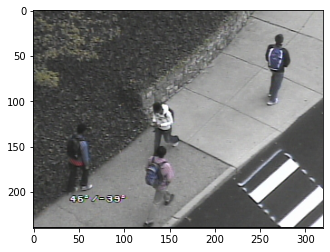

In [38]:
# the input image
target = imageio.imread("target.jpg")
plt.imshow(target)

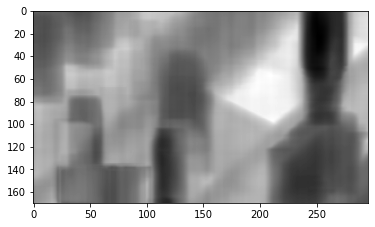

In [147]:
h, w, _ = target.shape

y = np.arange(70).astype(np.float32)
x = np.arange(24).astype(np.float32)
yv, xv = np.meshgrid(y, x, indexing='ij')
yv = yv.flatten()[np.newaxis, :]
xv = xv.flatten()[np.newaxis, :]
R = target[:, :, 0].astype(np.float32)
G = target[:, :, 1].astype(np.float32) 
B = target[:, :, 2].astype(np.float32)

dists = np.zeros((h - 70, w - 24), dtype=np.float32)

for i in range(h - 70):
    for j in range(w - 24):
        feature = np.vstack((xv, yv,
                          R[i:i+70, j:j+24].flatten()[np.newaxis, :],
                          G[i:i+70, j:j+24].flatten()[np.newaxis, :],
                          B[i:i+70, j:j+24].flatten()[np.newaxis, :]))
        cov = np.cov(feature, bias=True)
        evals = eigh(modelCovMatrix, cov, eigvals_only=True)
        dist = np.sqrt((np.log(evals)**2).sum())
        dists[i, j] = dist

minPos = dists.argmin()
minPos = minPos // (w - 24), minPos % (w - 24)
# the match-distance-image
plt.imshow(dists, cmap="gray")
plt.show()
imageio.imwrite("best_match.jpg", target[minPos[0]:minPos[0] + 70, minPos[1]:minPos[1] + 24])

(23, 251)


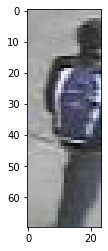

In [148]:
# output
# display the best match imgae
b_m = imageio.imread("best_match.jpg")
plt.imshow(b_m)
# the location of best match image 
print(minPos)

# Problem 2

In [122]:
# create a function to extract a feature vector 
def circularNeighbors(img, x, y, radius):
    X = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if (i - y) ** 2 + (j - x) ** 2 < radius ** 2:
                X.append(np.array([j, i, img[i, j, 0], img[i, j, 1], img[i, j, 2]]))

    return np.array(X).astype(np.float32)

# Problem 3

In [139]:
# a function to build a color histogram
def colorHistogram(X, bins, x, y, h):
    hist = np.zeros((bins, bins, bins), dtype=np.float32)
    step = (255. + 1e-2) / bins
    
    for i in range(X.shape[0]):
        feature = X[i]
        R = int(feature[2] // step)
        G = int(feature[3] // step)
        B = int(feature[4] // step)
        px = feature[0]
        py = feature[1]

        r = ((py - y) ** 2 + (px - x) ** 2) / (h ** 2)
        hist[R, G, B] += 1 - r

    hist = hist / hist.sum()

    return hist

# Problem 4

In [143]:
# create a function to calculate
def meanshiftWeights(X, q_model, p_test, bins):
    div = np.zeros((bins, bins, bins), dtype=np.float32)
    eps = 1e-4
    valid = p_test >= eps
    div[valid] = np.sqrt(q_model[valid] / p_test[valid])

    w = []
    step = (255. + 1e-2) / bins
    for i in range(X.shape[0]):
        feature = X[i]
        R = int(feature[2] // step)
        G = int(feature[3] // step)
        B = int(feature[4] // step)
        w.append(div[R, G, B])

    return np.array(w)

# Problem 5

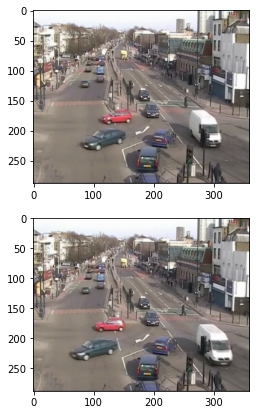

In [128]:
# the input images
img1 = imageio.imread("img1.jpg")
img2 = imageio.imread("img2.jpg")
plt.figure(figsize=(7,7))
plt.subplot(2,1,1)
plt.imshow(img1)
plt.subplot(2,1,2)
plt.imshow(img2)

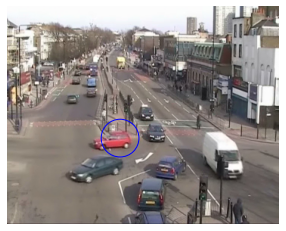

In [140]:
x0, y0 = 149., 174. 
radius = 25.
bins = 16
h = 25
X = circularNeighbors(img1, x0, y0, radius)
q_model =colorHistogram(X, bins, x0, y0, h)

# draw the circle
plt.imshow(img1)
circle1 = plt.Circle((x0, y0), radius=25, color='b', fill=False)
plt.gcf().gca().add_artist(circle1)
plt.axis('off')
plt.show()

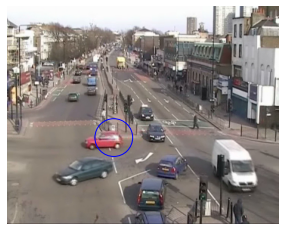

In [156]:
# run 25 iterations of mean-shift tracking on 
loc = np.array([x0, y0])
for i in range(25):
    X2 = circularNeighbors(img2, loc[0], loc[1], radius)
    p_test = colorHistogram(X2, bins, loc[0], loc[1], radius)
    w = meanshiftWeights(X2, q_model, p_test, bins)
    new_loc = (w[:, np.newaxis] * X2[:, :2]).sum(axis=0) / w.sum()
    dist =  np.sqrt(((new_loc - loc) ** 2).sum())
    loc = new_loc

# draw the circle 
x0 = new_loc[0]
y0 = new_loc[1]
plt.clf()
plt.imshow(img2)
circle2 = plt.Circle((x0, y0), radius=25, color='b', fill=False)
plt.gcf().gca().add_artist(circle2)
plt.axis('off')
plt.show()

In [155]:
# the final (x,y) location and distance
print(x0,y0)
print(dist)

140.67308 173.30669
6.473756e-05
